#### Linked Structures:PROPERTIES:



##### Agenda



1.  Motives
2.  Objectives
3.  Mechanisms
4.  Linked Data Structures



##### 1.  Import arraylists for demonstration



###### The `ArrayList` data structure



-   **Array API**:
    -   create array of size `n`
    -   access element at position `i`
    -   set the element at position `i`
    -   get length of array `len(array)`



In [1]:
class MyArray:

    def __init__(self,n):
        self.data = [None] * n
        self.len = n

    def __getitem__(self, idx):
        """Implements `x = self[idx]`"""
        assert(isinstance(idx, int) and self.len > idx)
        return self.data[idx]

    def __setitem__(self, idx, value):
        """Implements `self[idx] = x`"""
        assert(isinstance(idx, int) and self.len > idx)
        self.data[idx] = value

    def __len__(self):
        """Implements `len(self)`"""
        return self.len

    def __repr__(self):
        """Supports inspection"""
        return "[" + ",".join([str(x) for x in self.data]) + "]"

In [1]:
class MyActualArrayList:
    def __init__(self,n=10):
        self.data = MyArray(n)
        self.len = 0

    def append(self, value): # append, yah in O(n)
        if len(self.data) <= self.len:
            newa = MyArray(2 * len(self.data)) # n
            for i in range(0, self.len): # n
                newa[i] = self.data[i]   # n
            self.data = newa             # 1
        self.data[self.len] = value       # 1
        self.len += 1                # 1

    def __getitem__(self, idx): # O(1)
        """Implements `x = self[idx]`"""
        assert(isinstance(idx, int) and idx < self.len)
        return self.data[idx]

    def __setitem__(self, idx, value): # O(1)
        """Implements `self[idx] = x`"""
        assert(isinstance(idx, int) and idx < self.len)
        self.data[idx] = value

    def __delitem__(self, idx):
        """Implements `del self[idx]`"""
        assert(isinstance(idx, int) and idx < self.len)
        for i in range(idx+1, self.len):
            self.data[i-1] = self.data[i]
        self.len += -1

    def __len__(self):
        """Implements `len(self)`"""
        return self.len

    def __repr__(self):
        """Supports inspection"""
        return self.data.data[0:self.len].__repr__()

##### 1.  Motives



-   deleting the first element of an arraylist is in linear time



# Out[217]:
<module 'matplotlib.pyplot' from '/Users/lord_pretzel/.pyenv/versions/3.9.0/lib/python3.9/site-packages/matplotlib/pyplot.py'>

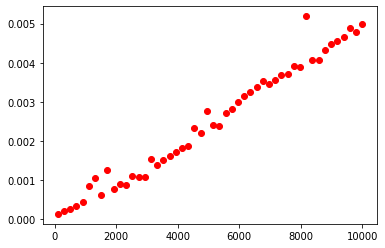

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from timeit import timeit

def time_array_front_insert_delete(n): # repeatedly append to the end and delete first
    return timeit('lst.insert(0, None) ; del lst[0]',
                    'lst = list(range({}))'.format(n),
                    number=1000)

ns = np.linspace(100, 10000, 50)
plt.plot(ns, [time_array_front_insert_delete(int(n)) for n in ns], 'ro')
plt

-   however, as discussed deleting from the end is $O(1)$ in both our implementation of `MyActualArrayList` and the Python list implementation



# Out[224]:
<module 'matplotlib.pyplot' from '/Users/lord_pretzel/.pyenv/versions/3.9.0/lib/python3.9/site-packages/matplotlib/pyplot.py'>

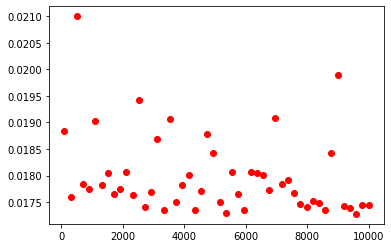

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from timeit import timeit

def time_array_end_delete(n):
    return timeit('lst.append(None) ; del lst[{} - 1]'.format(n),
                    'lst = list(range({}))'.format(n),
                    number=100000) # repeat this often enough to not measure the setup time of creating the list which is linear time

ns = np.linspace(100, 10000, 50)
plt.plot(ns, [time_array_end_delete(int(n)) for n in ns], 'ro')
plt

# Out[225]:
<module 'matplotlib.pyplot' from '/Users/lord_pretzel/.pyenv/versions/3.9.0/lib/python3.9/site-packages/matplotlib/pyplot.py'>

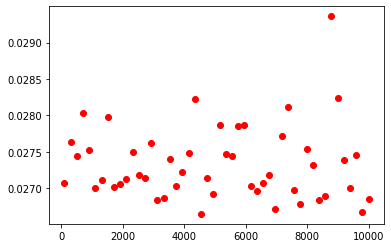

In [1]:
from timeit import timeit

# create the list upfront to not measure time of append
max = 10000
mylst = MyActualArrayList()
for i in range(0,max):
    mylst.append(1)

# report repeated insertion / deletion at the end
def time_our_array_list_end_delete(n):
    return timeit('lst.append(None); del lst[{} - 1]'.format(n),
                  'from __main__ import MyActualArrayList; '
                  'lst = mylst; '
                  'lst.len = {}'.format(n),
                  globals=globals(),
                  number=10000)

ns = np.linspace(100, max, 50)
plt.plot(ns, [time_our_array_list_end_delete(int(n)) for n in ns], 'ro')
plt

-   note that this is constant time!



###### Runtime of concatenating lists



In [1]:
# consider:

def concatenate(arr1, arr2):
    """Concatenates the contents of arr1 and arr2 as efficiently (time-wise)
    as possible, so that the resulting structure can be used to index all
    combined elements (arr1's followed by arr2's)."""

    # option 1: O(?)
    for x in arr2:
        arr1.append(x)
        return arr1

def concatenate2(arr1, arr2):
    # option 2: O(?)
    arr1.extend(arr2)
    return arr1

def concatenate3(arr1, arr2):
    # option 3: O(?)
    return arr1 + arr2

:results:
 # Out[33]:
 :end:

-   this is linear time in the length of the input lists



:results:
 # Out[226]:
 : <module 'matplotlib.pyplot' from '/Users/lord_pretzel/.pyenv/versions/3.9.0/lib/python3.9/site-packages/matplotlib/pyplot.py'>
 
 :end:

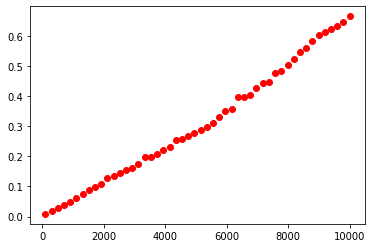

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from timeit import timeit

def time_array_front_insert_delete(n):
    return timeit('for x in lst2: lst1.append(x)',
                    'lst1 = list(range({})); lst2 = list(range({}))'.format(n,n),
                    number=1000)

ns = np.linspace(100, 10000, 50)
plt.plot(ns, [time_array_front_insert_delete(int(n)) for n in ns], 'ro')
plt

##### 1.  Objectives



We would like a new data storage mechanism for constructing data structures that:

-   does not require monolithic, contiguous memory allocation
-   allows individual elements to be flexibly and efficiently reorganized
    -   e.g., maybe even concatenation could be efficient
-   and preserves the ability to locate (e.g., via position) and iterate over elements



##### 1.  Mechanisms



###### 3.1. Two-Element Lists



In [1]:
# data items
i1 = 'lions'
i2 = 'tigers'
i3 = 'bears'
i4 = 'oh, my'
[i1, i2, i3, i4]

# Out[228]:
['lions', 'tigers', 'bears', 'oh, my']

In [1]:
# creating individual "links"
l4 = [i4,None]
l3 = [i3,l4]
l2 = [i2,l3]
l1 = [i1,l2]
l1

# Out[229]:
['lions', ['tigers', ['bears', ['oh, my', None]]]]

In [1]:
# link-ing them together

In [1]:
# iteration
def printlist(head):
    cur = head
    while cur != None:
        print(cur[0])
        cur = cur[1]
printlist(l1)

lions
tigers
bears
oh, my

In [1]:
# prepending
i0 = 'walruses'
l0 = [i0,l1]
head = l0
printlist(head)

walruses
lions
tigers
bears
oh, my

In [1]:
def prepend_list(head, el): # O(1)
    newcell = [el,head] # 1
    return newcell      # 1

newhead = prepend_list(l1, 'walruses')
printlist(newhead)

walruses
lions
tigers
bears
oh, my

In [1]:
# index access
def get_linked_list(head, pos): # O(n)
    cur = head                # 1
    for i in range(0,pos):    # O(n)
        cur = cur[1]          # O(n)
        if not cur:           # O(n)
            raise IndexError() # 1
    return cur[0]             # 1
get_linked_list(newhead,3)

# Out[247]:
'bears'

In [1]:
# insertion
def insert_linked_list(head, pos, el): # O(n)
    cur = head
    for i in range(0,pos):
        cur = cur[1]
        if not cur:
            raise IndexError()
    newel = [ el, cur[1] ]
    cur[1] = newel
i2_5 = 'elephants'
for i in range(0,4):
    insert_linked_list(l0,2,i2_5) # did run it 4 times
printlist(head)

walruses
lions
tigers
elephants
elephants
elephants
elephants
bears
oh, my

In [1]:
# find cell
def get_cell_at_pos(head,pos):
    cur = head
    for i in range(0,pos):
        cur = cur[1]
    return cur

# deletion
def delete_linked_list(head,pos): # does not work the first element
    cur = get_cell_at_pos(head,pos-1)
    nxt = cur[1]
    cur[1] = nxt[1]

delete_linked_list(head,3)
printlist(head)

walruses
lions
tigers
elephants
elephants
elephants
bears
oh, my

In [1]:
delete_linked_list(head,3)
delete_linked_list(head,3)
delete_linked_list(head,3)
printlist(head)

# Out[253]:

###### 3.2. "Link" objects



In [1]:
class Link:
    def __init__(self, val, next=None):
        self.val = val
        self.next = next

    def __str__(self):
        return self.__repr__()

    def __repr__(self):
        nextrep = "None" if not self.next else self.next.__repr__()
        return f"Link({self.val.__repr__()},{nextrep})"

# Out[262]:

In [1]:
# manually constructing a list
head = Link('lions',Link('bear',Link('fleas',None)))
print(head)

Link('lions',Link('bear',Link('fleas',None)))

In [1]:
# prepending
def prepend(l, val):
    return Link(val,l)

# Out[264]:

In [1]:
l = None
for x in range(10):
    l = prepend(l, x)
l

# Out[266]:
Link(9,Link(8,Link(7,Link(6,Link(5,Link(4,Link(3,Link(2,Link(1,Link(0,None))))))))))

In [1]:
# iterator
def link_iterator(l):
    cur = l
    while cur.next:
        yield cur.val
        cur = cur.next

# Out[270]:

In [1]:
for x in link_iterator(l):
    print(x)

9
8
7
6
5
4
3
2
1

In [1]:
# iteration based on a recursive pattern
def link_iterator_rec(l):
    if l:
        yield l.val
        for val in link_iterator_rec(l.next):
            yield val

# Out[280]:

In [1]:
for x in link_iterator_rec(l):
    print(x)

9
8
7
6
5
4
3
2
1
0

##### 1.  Linked Data Structures



###### 4.1 Linked List



In [1]:
class LinkedList:
    class Link:
        def __init__(self, val, next=None):
            self.val = val
            self.next = next

    def __init__(self):
        self.head = None
        self.len = 0

    def __len__(self):     # O(n)
        return self.len

    def normalize_index(self,i):
        assert(i >= -len(self) and i < len(self))
        if i < 0:  # -i to accessing from back of list
            i = len(self) + i
        return i

    def find_link(self, pos): # O(n)
        assert(pos >= 0 and pos < len(self))
        cur = self.head
        for i in range(0,pos):
            cur = cur.next
            if not cur:
                raise IndexError()
        return cur

    def __getitem__(self, index):
        nindex = self.normalize_index(index)
#        print(nindex)
        return self.find_link(nindex).val

    def __setitem__(self, index, val):
        nindex = self.normalize_index(index)
        cur = self.find_link(nindex)
        cur.val = val

    def prepend(self, val):
        self.head = self.Link(val,self.head)
        self.len += 1

    def insert(self, pos, val): # O(n)
        npos = self.normalize_index(pos)
        assert(npos >= 0 and npos <= len(self))
        if npos == 0:
            self.prepend(val)
        else:
            link =  self.find_link(npos - 1) # call to find_link is O(n)
            newcell = self.Link(val, link.next)
            link.next = newcell
        self.len += 1

    def __delitem__(self, pos): # O(n)
        npos = self.normalize_index(pos)
        assert(npos >= 0 and npos < len(self))
        if npos == 0:
            self.head = self.head.next
        else:
            cur = self.find_link(npos - 1) # call to find_link is O(n)
            cur.next = cur.next.next
        self.len += -1

    def __iter__(self):
        cur = self.head
        while cur:
            yield cur.val
            cur = cur.next

    def concat(self,other):
        if len(self) == 0:
            self.head = other.head
        else:
            self.tail.next = other.head                # O(1)
            self.tail = other.tail
        # for el in other:              # n
        #     self.insert(self.len,el)  # n * n = O(n^2)

    def reserve(self): # for example [1,2,3] -> [3,2,1] O(n)
        pass # return reversed list

    def __repr__(self):
        return '[' + ', '.join(str(x) for x in self) + ']'

# Out[33]:

In [1]:
l = LinkedList()
for x in range(10):
    l.prepend(x)
l

# Out[12]:
[9, 8, 7, 6, 5, 4, 3, 2, 1, 0]

In [1]:
l2 = LinkedList()
for x in range(10):
    l2.prepend(x)
del l2[0]
del l2[3]
l2

# Out[40]:
[8, 7, 6, 4, 3, 2, 1, 0]

###### 4.2 Binary Tree



In [1]:
class BinaryLink:
    def __init__(self, val, left=None, right=None):
        self.val = val
        self.left = left
        self.right = right

# Out[2]:

In [1]:
# manual construction of a "tree" representing the expression ((5+3)*(8-4))
t = BinaryLink('*')
t.left = BinaryLink('+')
t.left.left  = BinaryLink('5')
t.left.right = BinaryLink('3')
t.right = BinaryLink('-')
t.right.left  = BinaryLink('8')
t.right.right = BinaryLink('4')

# Out[3]:

In [1]:
def print_expr_tree(t):
    if t:
        if not t.val.isdigit():
            print('(', end='')
        print_expr_tree(t.left)
        print(t.val, end='')
        print_expr_tree(t.right)
        if not t.val.isdigit():
            print(')', end='')

# Out[4]:

In [1]:
print_expr_tree(t)

((5+3)*(8-4))

###### 4.3 N-ary Tree



In [1]:
class NaryLink:
    def __init__(self, val, n=2):
        self.val = val
        self.children = [None] * n

    def __getitem__(self, idx):
        return self.children[idx]

    def __setitem__(self, idx, val):
        self.children[idx] = val

    def __iter__(self):
        for c in self.children:
            yield c

# Out[7]:

In [1]:
root = NaryLink('Kingdoms', n=5)

root[0] = NaryLink('Animalia', n=35)
root[1] = NaryLink('Plantae', n=12)
root[2] = NaryLink('Fungi', n=7)
root[3] = NaryLink('Protista', n=5)
root[4] = NaryLink('Monera', n=5)

root[2][0] = NaryLink('Chytridiomycota')
root[2][1] = NaryLink('Blastocladiomycota')
root[2][2] = NaryLink('Glomeromycota')
root[2][3] = NaryLink('Ascomycota')
root[2][4] = NaryLink('Basidiomycota')
root[2][5] = NaryLink('Microsporidia')
root[2][6] = NaryLink('Neocallimastigomycota')

root[0][0] = NaryLink('Mamalia')
root[0][1] = NaryLink('Fish')

def tree_iter(root):
    if root:
        yield root.val
        for c in root:
            yield from tree_iter(c)

def treepp(root,depth=0):
    if root:
        print(depth * '\t' + root.val)
        for c in root:
            treepp(c,depth+1)

# Out[13]:

In [1]:
treepp(root)

Kingdoms
	Animalia
		Mamalia
		Fish
	Plantae
	Fungi
		Chytridiomycota
		Blastocladiomycota
		Glomeromycota
		Ascomycota
		Basidiomycota
		Microsporidia
		Neocallimastigomycota
	Protista
	Monera